In [1]:
from fastai.collab import *
from fastai.tabular import *
import numpy as np
import matplotlib.pylab as plt
from scipy import stats

In [104]:
def get_data(path, transformation = None):
    df_raw = pd.read_excel(path)
    all_columns = df_raw.columns
    df_selected = df_raw[[all_columns[0]]+list(all_columns[14:])]
    df_Kd = df_selected.set_index('Cmpd_ID').unstack().reset_index(name='pKd').rename(columns={'level_0':'target_id', 
                                                                                  'Cmpd_ID':'compound_id'})
    df_Kd.dropna(inplace=True)
    df_Kd = df_Kd.astype({'pKd': str})
    df_Kd = df_Kd[~df_Kd.pKd.str.contains('<')].copy() # ignore those too small
    df_Kd = df_Kd.astype({'pKd': float})
    if transformation == None:
        target_name = 'pKd'
    else:
        target_name = 'pKd' + transformation.__name__
        df_Kd[target_name] = transformation(df_Kd['pKd'])
    
    return df_Kd, target_name

In [120]:
def plot_preds(pred, target, target_name='target'):
    # plot a comparison between prediction and actual result
    fig, ax = plt.subplots(1, 2)
    axis_min = np.min([np.array(pred).flatten().min(), np.array(target).flatten().min()])
    axis_max = np.max([np.array(pred).flatten().max(), np.array(target).flatten().max()])
    ax[0].scatter(pred, target, alpha=0.02)
    ax[0].set_xlim([axis_min, axis_max])
    ax[0].set_xlabel(target_name + ' prediction')
    ax[0].set_ylim([axis_min, axis_max])
    ax[0].set_ylabel(target_name + ' actual')
    ax[0].set_aspect('equal')
    slope, intercept, r_value, p_value, std_err = stats.linregress(pred, target.flatten())
    ax[0].set_title("r_squared: {}".format(r_value**2) + "slope: {}".format(slope))
    ax[1].hist(np.array(pred).flatten()-np.array(target).flatten(), np.linspace(-10, 10, 100))
    ax[1].set_title('Histogram of prediction-target')

In [2]:
path = Path('/home/jupyter/.fastai/data/kinase/nchembio.530-S2.xls')

In [105]:
df_Kd, target_name = get_data(path)

In [106]:
df_Kd['pKd'].describe()

count    103919.000000
mean          6.416357
std           0.964565
min           4.000000
25%           5.700000
50%           6.300000
75%           7.000000
max          11.100000
Name: pKd, dtype: float64

In [109]:
df_Kd.shape

(103919, 3)

In [108]:
df_Kd.columns

Index(['target_id', 'compound_id', 'pKd'], dtype='object')

# Generate data

In [110]:
Kd_data = CollabDataBunch.from_df(df_Kd, user_name='compound_id',
                                         item_name='target_id',
                                         rating_name=target_name, 
                                         pct_val=0.1,
                                         seed=40)

In [111]:
Kd_data.show_batch()

compound_id,target_id,target
1007,IRAK4,7.199999809265137
996,PRKCI,5.5
3612,STK6,4.5
1652,MAPK1,6.300000190734863
1753,ROCK1,7.800000190734863


# Model using embedding

In [112]:
Kd_learn = collab_learner(Kd_data, n_factors=20, y_range=[3.5, 11.5])

In [113]:
Kd_learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


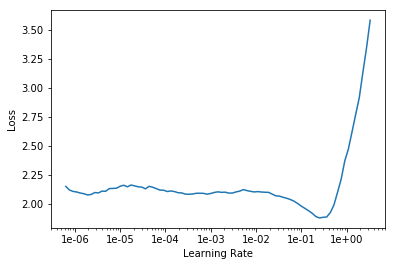

In [114]:
Kd_learn.recorder.plot()

In [115]:
Kd_learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss
1,0.559391,0.561442
2,0.405707,0.411792
3,0.297454,0.342931
4,0.205888,0.324556
5,0.147443,0.324771


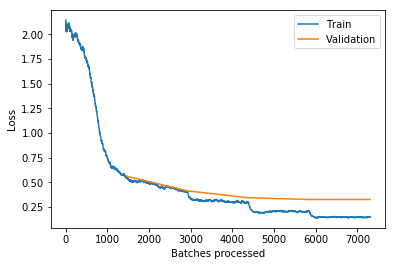

In [116]:
Kd_learn.recorder.plot_losses()

In [117]:
Kd_learn.show_results(rows=10)

compound_id,target_id,target,prediction
1773,PRKAA1,9.300000190734863,8.954599380493164
222,PRKACA,7.800000190734863,7.429862022399902
54,MAP4K4,7.699999809265137,7.511213302612305
1061,STK6,6.800000190734863,6.912962913513184
3450,MELK,6.400000095367432,6.5260443687438965
3716,RET,4.800000190734863,4.854468822479248
3731,PIM1,4.800000190734863,4.2701873779296875
529,MAP4K5,5.199999809265137,6.214716911315918
1453,MINK,7.199999809265137,6.726617336273193
2561,PDGFRB,5.699999809265137,6.276068687438965


In [118]:
Kd_preds = Kd_learn.get_preds(ds_type=DatasetType.Valid)

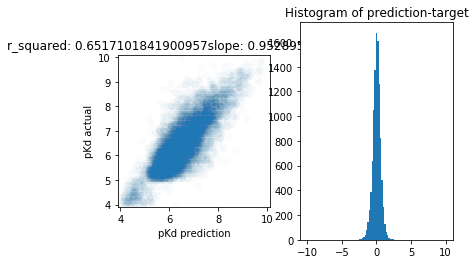

In [121]:
plot_preds(Kd_preds[0], Kd_preds[1], target_name)

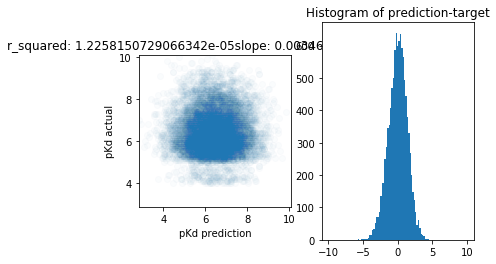

In [122]:
# bench mark: no prediction at all
random_preds = (np.random.randn(len(Kd_preds[1]))*df_Kd[target_name].describe()['std']+
                df_Kd[target_name].describe()['mean'])
plot_preds(random_preds, Kd_preds[1], target_name)

### There are a bunch of #na# in validation set for compound id. This is because these compounds were not found in the training dataset. For simplicity, let's ignore them for now. The result (r2) improves as expected.

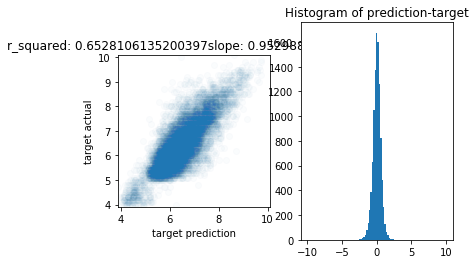

In [123]:
Kd_learn_valid_df = pd.DataFrame(data=[str(i).split(';')[0] for i in list(Kd_learn.data.valid_ds.x)],
                                 columns=['compound_id'])
Kd_learn_valid_df['target_id'] = [str(i).split(';')[1] for i in list(Kd_learn.data.valid_ds.x)]
Kd_learn_valid_df['prediction'] = Kd_preds[0]
Kd_learn_valid_df['target'] = Kd_preds[1]
plot_preds(np.array(Kd_learn_valid_df[(~Kd_learn_valid_df.compound_id.str.contains('#na#'))&
                                     (~Kd_learn_valid_df.target_id.str.contains('#na#'))]['prediction']),
           np.array(Kd_learn_valid_df[~Kd_learn_valid_df.compound_id.str.contains('#na#')&
                                     (~Kd_learn_valid_df.target_id.str.contains('#na#'))]['target']))

In [128]:
Kd_learn.fit_one_cycle(5, 5e-3) # extra 5 cycles don't really help

epoch,train_loss,valid_loss
1,0.143995,0.356988
2,0.195096,0.365866
3,0.173369,0.352156
4,0.128860,0.348447
5,0.090510,0.349765


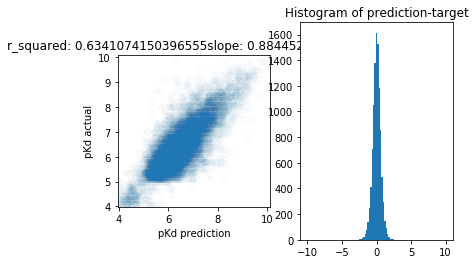

In [129]:
Kd_preds = Kd_learn.get_preds(ds_type=DatasetType.Valid)
plot_preds(Kd_preds[0], Kd_preds[1], target_name)

# Try PCA with wd=0.1, lr=0.005, n_factor = 30

In [137]:
Kd_learn = collab_learner(Kd_data, n_factors=30, y_range=[3.5, 11.5], wd=1e-1)
Kd_learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [138]:
Kd_learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss
1,0.557595,0.569255
2,0.420114,0.429324
3,0.322217,0.359446
4,0.225695,0.324597
5,0.165736,0.321071


In [139]:
np.sum(Kd_learn_valid_df.target_id.str.contains('#na#'))

0

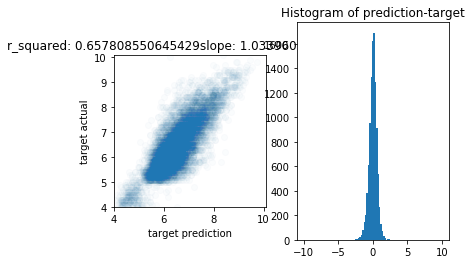

In [140]:
# get rid of those cold starts
Kd_preds = Kd_learn.get_preds(ds_type=DatasetType.Valid)
Kd_learn_valid_df = pd.DataFrame(data=[str(i).split(';')[0] for i in list(Kd_learn.data.valid_ds.x)],
                                 columns=['compound_id'])
Kd_learn_valid_df['target_id'] = [str(i).split(';')[1] for i in list(Kd_learn.data.valid_ds.x)]
Kd_learn_valid_df['prediction'] = Kd_preds[0]
Kd_learn_valid_df['target'] = Kd_preds[1]
plot_preds(np.array(Kd_learn_valid_df[(~Kd_learn_valid_df.compound_id.str.contains('#na#'))&
                                     (~Kd_learn_valid_df.target_id.str.contains('#na#'))]['prediction']),
           np.array(Kd_learn_valid_df[~Kd_learn_valid_df.compound_id.str.contains('#na#')&
                                     (~Kd_learn_valid_df.target_id.str.contains('#na#'))]['target']))

In [150]:
# find most frequent compunds
top_compounds = df_Kd.groupby('compound_id')[target_name].count().sort_values(ascending=False).index.values[:100].astype(str)
top_compounds_weights = Kd_learn.weight(top_compounds, is_item=False)
top_compounds_weights_pca = top_compounds_weights.pca(3)
fac0, fac1, fac2 = top_compounds_weights_pca.t()
df_weights = pd.DataFrame({'compound_id': top_compounds,
                           'fac0': fac0,
                           'fac1': fac1,
                           'fac2': fac2})

In [151]:
df_weights.sort_values('fac0', ascending=False).head()

,compound_id,fac0,fac1,fac2
77,34,0.612841,0.141863,-0.023295
57,1447,0.574955,0.060761,0.122126
5,1,0.565273,-0.358532,-0.270815
54,57,0.562119,0.116977,-0.022999
43,12,0.509011,-0.101183,-0.106076


In [152]:
df_weights.sort_values('fac1', ascending=False).head()

,compound_id,fac0,fac1,fac2
79,1212,-0.239244,0.521957,0.084946
56,1200,-0.025668,0.490421,-0.122355
41,414,0.044374,0.466736,0.287919
97,675,-0.264492,0.449306,0.293991
94,558,0.286989,0.434057,0.121074


In [153]:
df_weights.sort_values('fac2', ascending=False).head()

,compound_id,fac0,fac1,fac2
38,956,-0.102013,-0.027163,0.382005
25,992,-0.384379,-0.378783,0.367683
55,958,-0.212561,-0.354856,0.355123
19,963,-0.246392,-0.442713,0.329247
96,661,-0.256404,-0.358149,0.299980


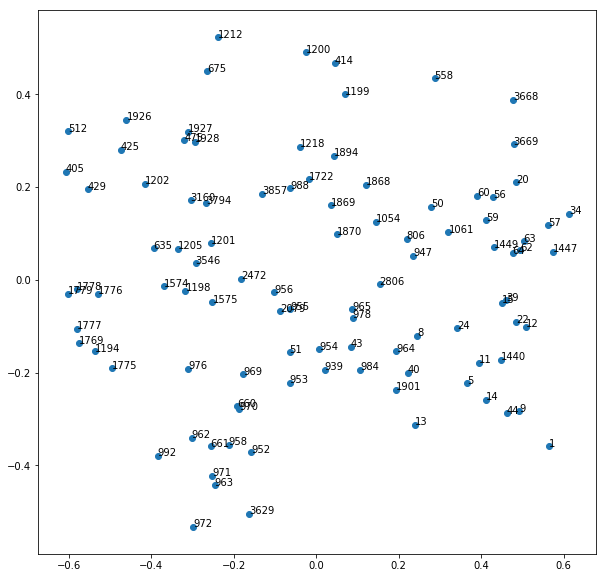

In [154]:
plt.figure(figsize=(10, 10))
plt.scatter(df_weights.fac0, df_weights.fac1)
for (id, x, y) in zip(df_weights.compound_id, df_weights.fac0, df_weights.fac1):
    plt.text(x, y, id)

In [155]:
# find most frequent kinase
top_kinase = df_Kd.groupby('target_id')[target_name].count().sort_values(ascending=False).index.values[:100]
top_kinase_weights = Kd_learn.weight(top_kinase, is_item=True)
top_kinase_weights_pca = top_kinase_weights.pca(3)
fac0, fac1, fac2 = top_kinase_weights_pca.t()
df_kinase_weights = pd.DataFrame({'target_id': top_kinase,
                           'fac0': fac0,
                           'fac1': fac1,
                           'fac2': fac2})

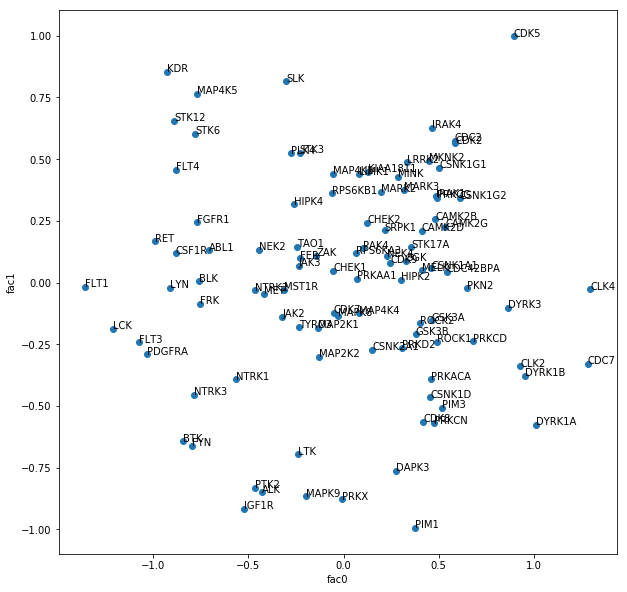

In [156]:
plt.figure(figsize=(10, 10))
plt.scatter(df_kinase_weights.fac0, df_kinase_weights.fac1)
plt.xlabel('fac0')
plt.ylabel('fac1')
for (id, x, y) in zip(df_kinase_weights.target_id, df_kinase_weights.fac0, df_kinase_weights.fac1):
    plt.text(x, y, id)

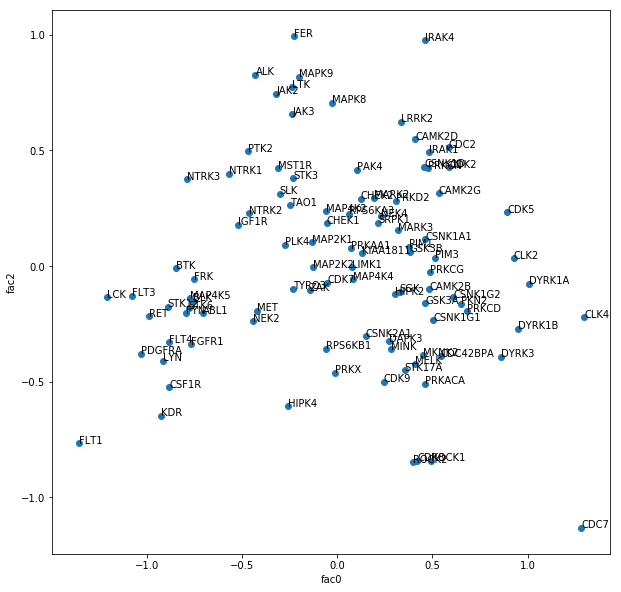

In [157]:
plt.figure(figsize=(10, 10))
plt.scatter(df_kinase_weights.fac0, df_kinase_weights.fac2)
plt.xlabel('fac0')
plt.ylabel('fac2')
for (id, x, y) in zip(df_kinase_weights.target_id, df_kinase_weights.fac0, df_kinase_weights.fac2):
    plt.text(x, y, id)

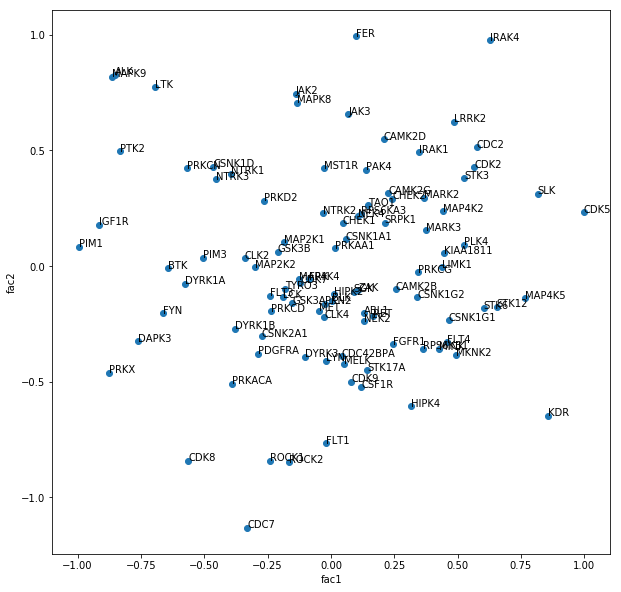

In [158]:
plt.figure(figsize=(10, 10))
plt.scatter(df_kinase_weights.fac1, df_kinase_weights.fac2)
plt.xlabel('fac1')
plt.ylabel('fac2')
for (id, x, y) in zip(df_kinase_weights.target_id, df_kinase_weights.fac1, df_kinase_weights.fac2):
    plt.text(x, y, id)

In [159]:
from sklearn.neighbors import NearestNeighbors

In [160]:
# find closest neighbors of each kinase using the principal components
kinase_nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(
                         df_kinase_weights[['fac0', 'fac1', 'fac2']])
distances, indices = kinase_nbrs.kneighbors(df_kinase_weights[['fac0', 'fac1', 'fac2']])
df_kinase_weights.loc[:, 'pca_NN'] = df_kinase_weights.loc[np.transpose(indices)[1], 'target_id'].values.flatten()

In [161]:
df_kinase_weights.head()

,target_id,fac0,fac1,fac2,pca_NN
0,CLK4,1.296979,-0.026474,-0.222294,DYRK3
1,MAP4K4,0.081267,-0.125043,-0.057453,CDK7
2,GSK3B,0.379846,-0.209787,0.061662,PRKD2
3,STK12,-0.890387,0.654886,-0.175473,STK6
4,KDR,-0.928393,0.855212,-0.647725,FLT4


In [42]:
df_kinase_weights.loc[0, :]

target_id      P00519
fac0         -0.17216
fac1         0.505359
fac2         0.179844
Name: 0, dtype: object

# grid search: lr is the most important hyperparameter. For wd or n_factors, there are always good parameter combinations, but for a bad lr, it would be hard to get a good result.

In [162]:
wds = np.logspace(-3, 0, 4)
lrs = np.logspace(-4, -1, 4) * 0.5
n_factors = np.linspace(10, 100, 10)
df_grid_search = pd.DataFrame(columns=['wd', 'lr', 'n_factor', 'r2'])
for (wd, lr, n_factor) in itertools.product(wds, lrs, n_factors):
    print(wd, lr, n_factor)
    Kd_learn = collab_learner(Kd_data, n_factors=int(n_factor), y_range=[-3.5, 11.5], wd=wd)
    Kd_learn.fit_one_cycle(5, lr)
    Kd_preds = Kd_learn.get_preds(ds_type=DatasetType.Valid)
    Kd_learn_valid_df = pd.DataFrame(data=[str(i).split(';')[0] for i in list(Kd_learn.data.valid_ds.x)],
                                 columns=['compound_id'])
    Kd_learn_valid_df['target_id'] = [str(i).split(';')[1] for i in list(Kd_learn.data.valid_ds.x)]
    Kd_learn_valid_df['prediction'] = Kd_preds[0]
    Kd_learn_valid_df['target'] = Kd_preds[1]
    r_value = stats.linregress(np.array(Kd_learn_valid_df[(~Kd_learn_valid_df.compound_id.str.contains('#na#'))&
                                                         (~Kd_learn_valid_df.target_id.str.contains('#na#'))]['prediction']),
           np.array(Kd_learn_valid_df[~Kd_learn_valid_df.compound_id.str.contains('#na#')]['target']))[2]
    df_grid_search = df_grid_search.append({'wd': wd, 'lr': lr, 'n_factor': n_factor, 'r2': r_value**2}, 
                                           ignore_index = True)


Text(0.5,0,'n_factor')

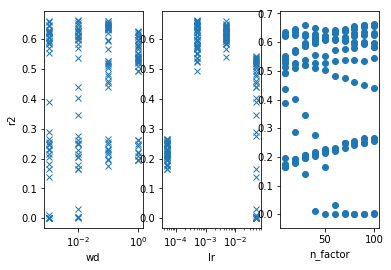

In [131]:
fig, ax = plt.subplots(1, 3)
ax[0].semilogx(df_grid_search.wd, df_grid_search.r2, 'x')
ax[0].set_xlabel('wd')
ax[0].set_ylabel('r2')
ax[1].semilogx(df_grid_search.lr, df_grid_search.r2, 'x')
ax[1].set_xlabel('lr')
ax[2].scatter(df_grid_search.n_factor, df_grid_search.r2)
ax[2].set_xlabel('n_factor')

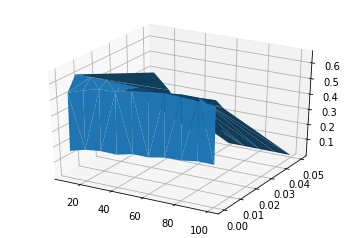

In [132]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(df_grid_search.n_factor, df_grid_search.lr, df_grid_search.r2)

In [134]:
df_grid_search.sort_values('r2', ascending=False).head(10)

,wd,lr,n_factor,r2
59,0.010,0.0005,100.0,0.661991
99,0.100,0.0005,100.0,0.660544
102,0.100,0.0050,30.0,0.660331
58,0.010,0.0005,90.0,0.660107
18,0.001,0.0005,90.0,0.659620
19,0.001,0.0005,100.0,0.657736
57,0.010,0.0005,80.0,0.654834
98,0.100,0.0005,90.0,0.654197
103,0.100,0.0050,40.0,0.649180
17,0.001,0.0005,80.0,0.648167


# embedding NN (https://towardsdatascience.com/collaborative-filtering-with-fastai-3dbdd4ef4f00)

In [269]:
Kd_NN = collab_learner(Kd_data, use_nn=True, 
                       emb_szs={'compound_id': 40, 'target_id':40}, layers=[256, 128], y_range=(-20, 30))

In [270]:
Kd_NN.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


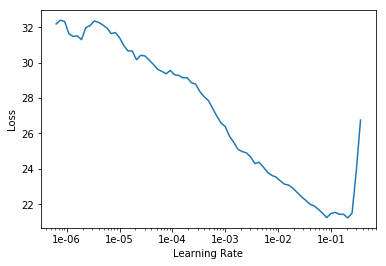

In [271]:
Kd_NN.recorder.plot()

In [272]:
Kd_NN.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss
1,8.092835,7.002777
2,7.083485,6.826031
3,5.260640,6.407361
4,4.042236,5.750410
5,3.379128,5.433368
6,2.762931,5.120790
7,2.096077,5.052482
8,1.783967,4.964086
9,1.583162,5.192410
10,1.353708,5.019313


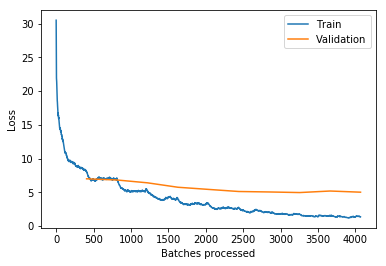

In [273]:
Kd_NN.recorder.plot_losses()

In [274]:
Kd_NN.show_results()

compound_id,target_id,target,prediction
CHEMBL2024149,P0DMS8,-0.8278220891952515,3.687488555908203
CHEMBL1544,P10827,-2.8473122119903564,-2.4090042114257812
CHEMBL265556,P30968,0.0,0.11651229858398438
CHEMBL1721885,Q9Y4K4,5.703782558441162,5.274375915527344
CHEMBL522892,Q16513,9.200289726257324,8.28076171875


In [275]:
Kd_NN_preds = Kd_NN.get_preds()

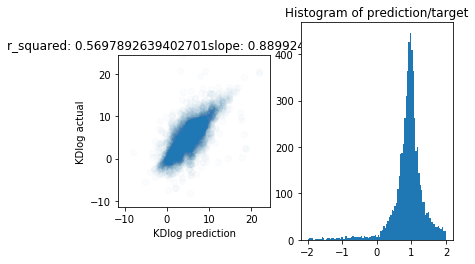

In [276]:
plot_preds(Kd_NN_preds[0].flatten(), Kd_NN_preds[1], target_name)

## TODO
1. #na# issue. see this https://forums.fast.ai/t/tabular-issue-spliting-to-validation-results-in-random-na-in-data/37268 (done)
1. explore the effect of embedding